In [1]:
from __future__ import unicode_literals
import os
import sys
# sys.path.append('../')
import datetime
import pandas as pd
import numpy as np
import datetime
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.dates as md
import matplotlib.dates as mdates
import random
import seaborn as sns
import json
%matplotlib inline
sys.path.append('../')
from matplotlib import font_manager, rc
from tools.utils import *
from pytz import timezone
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset, inset_axes

# font setup
font_dirs = ['../']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
plt.rcParams['font.family'] = 'Times New Roman'

data_path = '../enertalk-dataset/'
fig_width = 8.9
golden_mean = (np.sqrt(5)-1.0)/2.0    # Aesthetic ratio
fig_height = fig_width*golden_mean # height in inches

date_lst = pd.date_range('2016-09-01', '2017-04-30')
meta = pd.read_csv('meta.csv')
meta['app_name'] = meta['app'].str[3:]
meta = meta.loc[meta['app_name']=='total']

meta_dict = {}
time_lst = ['1s', '10s', '30s', '1m', '5m', '30m', '1h', '3h']

for psn in pd.unique(meta['psn']):
    meta_dict[psn] = {}
    for time_scale in time_lst:
        meta_dict[psn][time_scale] = 0
    meta_target = meta.loc[meta['psn']==psn]
    
    for date in sorted(pd.unique(meta_target['date'])):
        target_row = meta_target.loc[meta_target['date']==date]
        gap_count = get_dict(target_row['gap_count'].values[0])
        for time_scale in time_lst:
            meta_dict[psn][time_scale] += gap_count[time_scale]
    
    # normalize
    date_len = len(pd.unique(meta_target['date']))*1.0
    
    for time_scale in time_lst:
        meta_dict[psn][time_scale] = meta_dict[psn][time_scale]/date_len
        

summary = pd.DataFrame(meta_dict).transpose().sort_index()
summary = summary.reset_index()
summary = summary.rename({'index': 'House'}, axis='columns')
summary['House'] = summary['House'].astype(str)
summary['House'] = summary['House'].str.zfill(2)
summary = summary.fillna(0)
summary = summary.sort_values(by='House')
summary = summary.set_index('House')
summary = summary[time_lst]

summary.head()    

,1s,10s,30s,1m,5m,30m,1h,3h
House,,,,,,,,
00,804.689655,9.712644,0.770115,0.344828,0.034483,0.000000,0.000000,0.000000
01,562.559322,16.135593,1.889831,1.110169,0.500000,0.152542,0.076271,0.059322
02,145.129032,2.483871,0.290323,0.225806,0.032258,0.000000,0.000000,0.000000
03,579.743363,10.814159,0.769912,0.442478,0.097345,0.017699,0.008850,0.008850
04,156.000000,8.325581,0.976744,0.779070,0.081395,0.023256,0.000000,0.000000


# Visualize Figure 12. Average occurrence count of gaps for the 22 houses

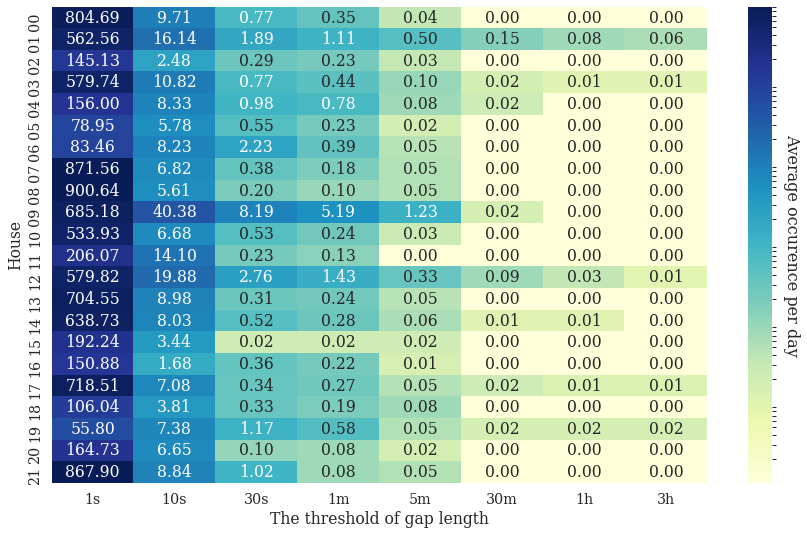

In [2]:
from matplotlib.colors import LogNorm
fig_width = 8.9
golden_mean = (np.sqrt(5)-1.0)/2.0    # Aesthetic ratio
fig_height = fig_width*golden_mean # height in inches

sns.set(font_scale=1.3)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

# fig, ax = plt.subplots(figsize=(20,20))
fig, ax = plt.subplots(figsize=(fig_width*1.4, fig_height*1.4))
epsilon = 0.001
summary_for_log = summary + epsilon
sns.heatmap(summary_for_log, norm=LogNorm(vmin=summary_for_log.min().min(), vmax=summary.max().max()),
            cmap="YlGnBu", 
            cbar_kws={'ticks':[], 'label': 'Average occurence per day'},
            annot=True, fmt=".2f")
plt.xlabel('The threshold of gap length')
fig.axes[-1].set_ylabel( 'Average occurence per day', fontsize=16, rotation=-90, va="bottom")
fig.tight_layout()
plt.show()
fig.savefig('../plots/gap_distribution_threshold.pdf', bbox_inches='tight', format='pdf', dpi=1000)